In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
import collections
import numpy as np

## task 01

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [2]:
def get_bootstrap(data, N):
    return np.random.randint(0, len(data), size = (N, len(data)))

In [3]:
def get_oof(bootstrap_idx):
    oof_idx = [
        list(set(range(len(bootstrap_idx[0]))) - set(bootstrap)) for bootstrap in bootstrap_idx
    ]
    return np.array(oof_idx)
    

In [4]:
# генерация подмножества признаков для нахождения разбиения в узле
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = collections.Counter()
        for label in self.labels:
            classes[label] += 1
            
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = collections.Counter()
    for label in labels:
        classes[label] += 1    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
# формирование случайного леса
def random_forest(data, labels, n_trees):
    forest, scores = [], []
    bootstrap_idx = get_bootstrap(data, n_trees)
    oof = get_oof(bootstrap_idx)
    
    for idx in bootstrap_idx:
        b_data, b_labels = data[idx], labels[idx]
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
    for idx in oof:
        oof_data, oof_labels = data[idx], labels[idx]
        for tree in forest:
            y_pred = predict(oof_data, tree)
            score = accuracy_metric(oof_labels, y_pred)
        scores.append(score)
    
       
    return forest, scores

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    classes = []
    
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [16]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    return (actual == predicted).sum() / float(len(actual)) * 100.0

In [17]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [18]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 1000,
                                                                          n_features = 2, 
                                                                          n_informative = 2, 
                                                                          n_classes = 2, 
                                                                          n_redundant = 0, 
                                                                          n_clusters_per_class = 1, 
#                                                                           flip_y = 0.2,
                                                                          random_state = 23)

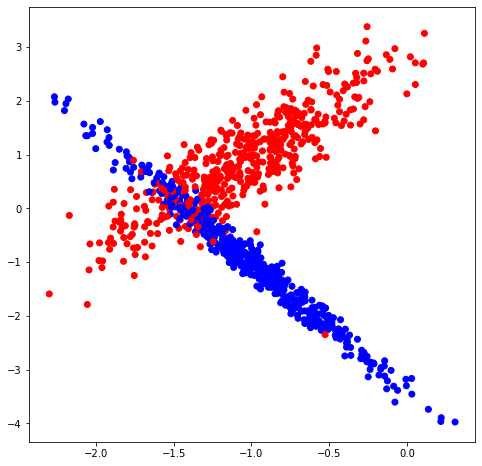

In [19]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [20]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

1 trees: train_accuracy 90.0, test_accuracy 96.33333333333334, oob_score 89.62264150943396


C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


3 trees: train_accuracy 90.57142857142857, test_accuracy 98.66666666666667, oob_score 94.76765585461237
10 trees: train_accuracy 91.57142857142857, test_accuracy 99.66666666666667, oob_score 94.13349350217207
50 trees: train_accuracy 91.0, test_accuracy 100.0, oob_score 91.60848509869227
100 trees: train_accuracy 90.85714285714286, test_accuracy 100.0, oob_score 95.44442976837388
200 trees: train_accuracy 91.0, test_accuracy 100.0, oob_score 95.88670921582481


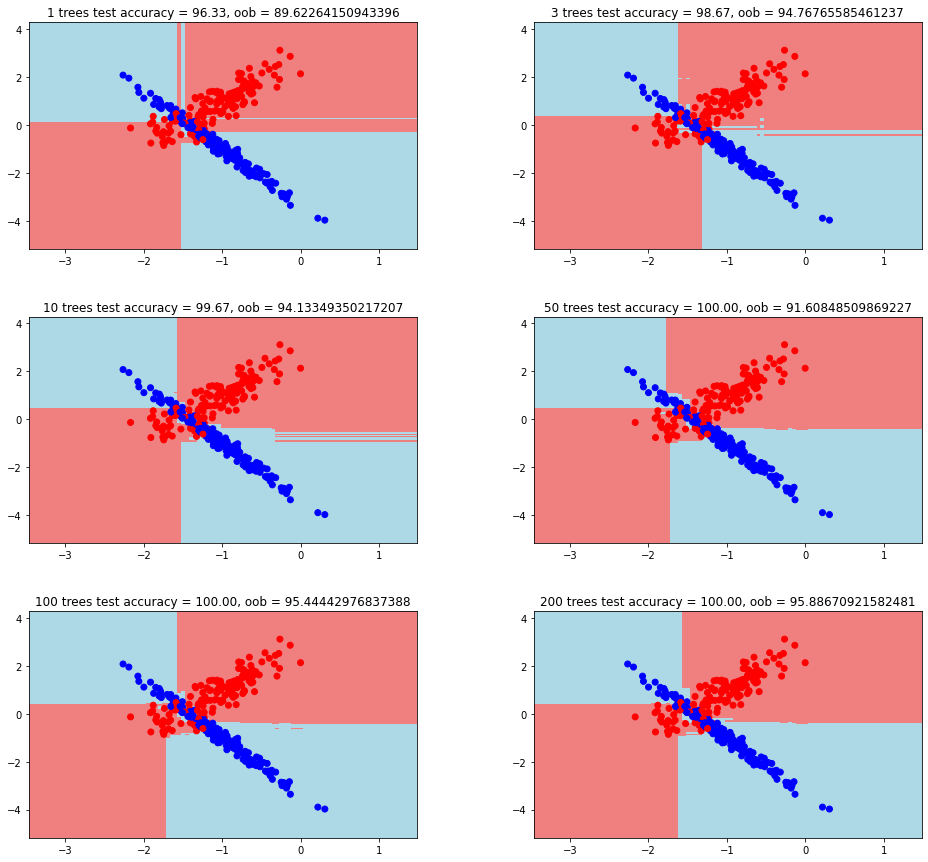

In [22]:
# trees = [1, 3, 10, 15, 20]
trees = [1, 3, 10, 50, 100, 200]
rows = (len(trees) + 1) // 2

fig, ax = plt.subplots(nrows = rows, ncols = 2)
fig.set_size_inches(16, 5 * rows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)


for n_trees in trees:

#     my_forest = random_forest(train_data, train_labels, n_trees)
#     train_answers = tree_vote(my_forest, train_data)
#     test_answers = tree_vote(my_forest, test_data)
#     train_accuracy = accuracy_metric(train_labels, train_answers)
#     test_accuracy = accuracy_metric(test_labels, test_answers)

    my_forest, my_scores = random_forest(test_data, test_labels, n_trees)
    test_answers = tree_vote(my_forest, test_data)
    train_answers = tree_vote(my_forest, train_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'{n_trees} trees: train_accuracy {train_accuracy}, test_accuracy {test_accuracy}, oob_score {np.mean(my_scores)}')

    axi = ax.flatten()[trees.index(n_trees)]
    xx, yy = get_meshgrid(test_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    axi.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    axi.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    axi.set_title(f'{n_trees} trees test accuracy = {test_accuracy:.2f}, oob = {np.mean(my_scores)}')


С увеличением количества деревьев сложность разделяющей гиперплоскости возрастает, но алгоритм при этом не переобучается